# fMRI Demo (nilearn version)

## About this demo

In this demo we'll show how to use the python *nilearn* library to create multi-voxel patterns and then how to use these in the *rsatoolbox* to create RDMs. See the [patterns demo](https://rsatoolbox.readthedocs.io/en/stable/demo_fmri_patterns.html) for a more birds-eye view of the analysis pipeline, with a larger portion of the dataset, including inference.

## The Dataset

The data used for this demo was kindly provided by Marieke Mur. This study is still under review, so we will update this demo to include steps to download the data when it becomes publicly available. 

Participants (n=14) viewed images of 16 objects, as well as their written name. Several properties of the stimuli were carefully balanced. They also performed several tasks, but for the purposes of this demo we will ignore these.

![stimuli](demo_fmri_files/mur32_stims.png)

This library depends on *nibabel* for convenience functions to access MRI data, and is used separately in the demo as well, so start by installing nibabel (`pip install nibabel`).

Then run the following imports:

In [29]:
%matplotlib inline
from os.path import expanduser, join
from rsatoolbox.io.fmriprep import find_fmriprep_runs, make_design_matrix
from rsatoolbox.data.dataset import Dataset, merge_datasets
from rsatoolbox.rdm.rdms import concat
from rsatoolbox.vis import show_rdm
from rsatoolbox.rdm.calc import calc_rdm
from rsatoolbox.data.noise import prec_from_residuals
import numpy, pandas, matplotlib.pyplot
import nilearn, nibabel, pandas

Now we define the path to the BIDS-root data directory

In [2]:
data_dir = expanduser('~/data/rsatoolbox/mur32')

Next we use a utility function to find the relevant preprocessed BOLD images:

In [3]:
runs = find_fmriprep_runs(data_dir, tasks=['main'])
len(runs)

84

Let's select all the runs for participant *sub-12*:

In [4]:
runs = [run for run in runs if run.boldFile.sub == '12']
len(runs)

6

Each run object carries the relevant data and metadata

In [5]:
run = runs[0]
run

<FmriprepRun [sub-12/ses-01/func/sub-12_ses-01_task-main_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz]>

In [6]:
dims = run.get_data(masked=True).shape ## bold timeseries: x * y * z * volumes
n_vols = dims[-1]
dims

(60152, 546)

Access the attributes stored in the *_metadata.json* for this file

In [7]:
tr = run.get_meta()['RepetitionTime'] ## TR in seconds
tr

2

We will also load the events table

In [8]:
run.get_events().sample(5) ## 5 random events

,onset,duration,trial_type,modality,identity,response_time,task,response_mapping
55,164.996,0.5,text_saddle,text,saddle,0.800,verbal,left-right
90,269.986,0.5,image_clock,image,clock,1.008,verbal,left-right
323,968.987,0.5,text_pedal,text,pedal,0.839,semantic,left-right
356,1067.991,0.5,baseline,NaN,NaN,NaN,NaN,NaN
84,251.996,0.5,image_candle,image,candle,1.462,verbal,left-right


In [9]:
run.get_confounds().head(3)

,global_signal,csf,white_matter,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,490.950364,852.897339,454.706819,-0.031540,-0.278969,-0.171883,0.003922,0.001695,-0.001443
1,488.731823,841.926156,454.439092,0.004438,-0.155145,-0.161355,0.004182,0.001695,-0.000628
2,488.417947,836.871638,454.370054,0.005771,-0.200537,-0.150666,0.004127,0.001523,-0.001216


## Patterns

Next we want to establish Multi-Voxel Patterns from the timeseries, such that, for each stimulus presentation, we have one observation per voxel. The most common way to do this is with a General Linear Model, where each predictor in the model reflects one type of event, convolved with the haemodynamic response function (HRF). For the purposes of this demo we will use a very basic glm implementation in Python. For a guide on MVPA, see [Mur et al. 2009](https://doi.org/10.1093/scan/nsn044).

First we use a utility function which creates predictors from the events table and convolves them with the HRF. Note that we have 34 predictors, with a value for each volume in the BOLD timeseries. 

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: modality, response_mapping, identity, task, response_time
  warnings.warn(


<Axes: label='conditions', ylabel='scan number'>

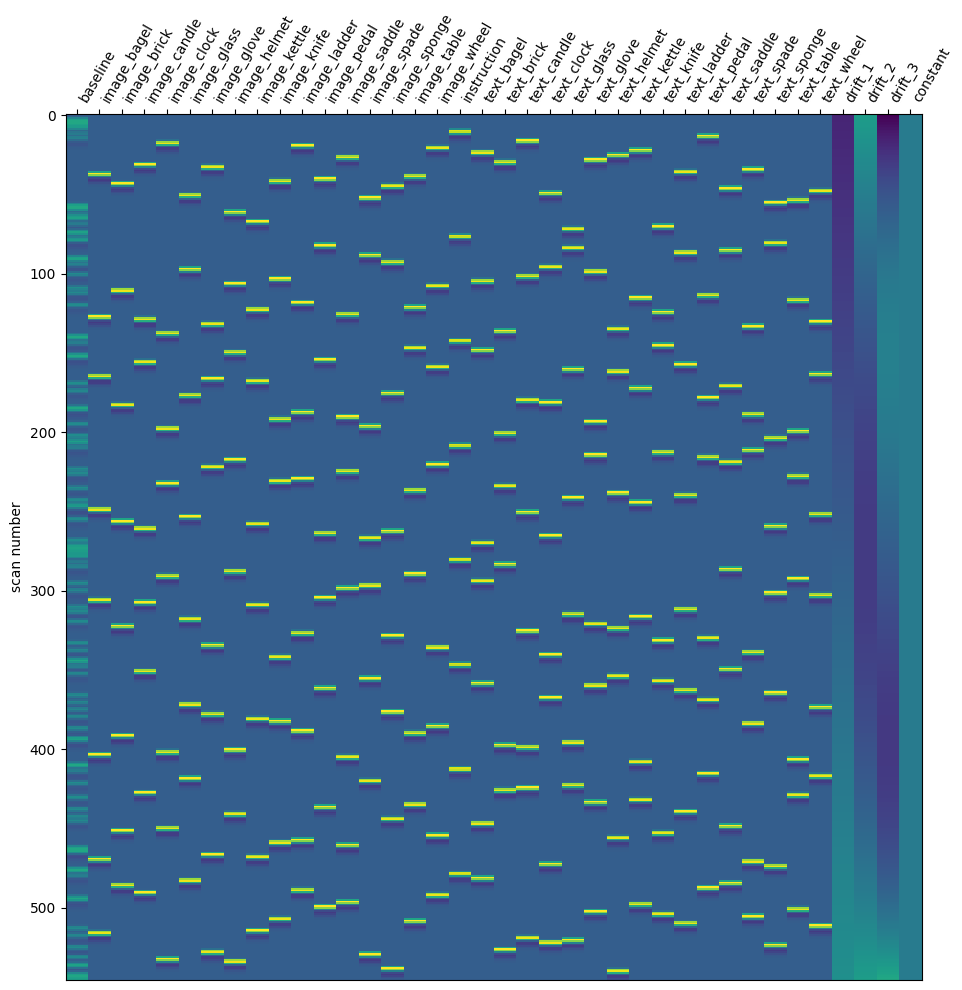

In [10]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

frame_times = numpy.linspace(0, tr*(n_vols-1), n_vols) ## [0, 2, 4] onsets of scans in seconds
design_matrix = make_first_level_design_matrix(frame_times, run.get_events(),
    drift_model='polynomial', drift_order=3)
plot_design_matrix(design_matrix)

This plot shows the design matrix. Every blip reflects the haemodynamic response to a single trial.

### GLM
Here we fit nilearn's implementation of the GLM (~1minute)

In [11]:
from nilearn.glm.first_level import FirstLevelModel
mask_fpath = run.boldFile.get_mri_sibling(desc='brain', suffix='mask').fpath
glm = FirstLevelModel(
    t_r=2.0,
    mask_img=mask_fpath,
    minimize_memory=False,
    signal_scaling=0,
)
glm.fit([run.boldFile.fpath], design_matrices=design_matrix)

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


FirstLevelModel(mask_img='/Users/jasper/data/rsatoolbox/mur32/derivatives/fmriprep/sub-12/ses-01/func/sub-12_ses-01_task-main_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                minimize_memory=False, t_r=2.0)

In [12]:
conditions = [c for c in design_matrix.columns if ('image_' in c) or ('text_' in c)]
conditions

['image_bagel',
 'image_brick',
 'image_candle',
 'image_clock',
 'image_glass',
 'image_glove',
 'image_helmet',
 'image_kettle',
 'image_knife',
 'image_ladder',
 'image_pedal',
 'image_saddle',
 'image_spade',
 'image_sponge',
 'image_table',
 'image_wheel',
 'text_bagel',
 'text_brick',
 'text_candle',
 'text_clock',
 'text_glass',
 'text_glove',
 'text_helmet',
 'text_kettle',
 'text_knife',
 'text_ladder',
 'text_pedal',
 'text_saddle',
 'text_spade',
 'text_sponge',
 'text_table',
 'text_wheel']

In [23]:
glm.compute_contrast('image_glove', output_type='effect_size')

The output of this is a statistical map; a whole-brain volume with a beta-weight for every voxel. 

## Defining a Region-of-Interest
We want to sample a pattern for a specific brain region. Luckily this *fmriprep* run comes with the *aparcaseg* parcellation map projected into the subject's space. Let's use this atlas to create a *mask* for the Fusiform Gyrus.

In [28]:
# Navigate to the aparcaseg file for this run:
aparc = run.boldFile.get_mri_sibling(desc='aparcaseg', suffix='dseg')
aparc_data = aparc.get_data()
print(aparc_data.shape)
print(numpy.unique(aparc_data[:10]))

(65, 77, 55)
[   0. 1001. 1015. 1022. 1030. 1031.]


As we see, this is a volume with an whole number at every voxel. We can use the corresponding lookup-table (LUT) to understand these numbers:

In [31]:
lut_fpath = join(data_dir, 'derivatives', 'fmriprep',
                 'desc-aparcaseg_dseg.tsv')
lut_df = pandas.read_csv(lut_fpath, sep='\t')
lut_df

,index,name,color
0,0,Unknown,#000000
1,1,Left-Cerebral-Exterior,#4682b4
2,2,Left-Cerebral-White-Matter,#f5f5f5
3,3,Left-Cerebral-Cortex,#cd3e4e
4,4,Left-Lateral-Ventricle,#781286
...,...,...,...
1369,14171,wm_rh_S_suborbital,#15143c
1370,14172,wm_rh_S_subparietal,#653c3c
1371,14173,wm_rh_S_temporal_inf,#15b4b4
1372,14174,wm_rh_S_temporal_sup,#dfdc3c


Now let's find the numbers that correspond to the Fusiform Gyrus in the left- and right hemisphere:

In [33]:
matches = lut_df[lut_df['name'] == 'ctx-lh-fusiform']
left_index = matches['index'].values[0]
matches = lut_df[lut_df['name'] == 'ctx-rh-fusiform']
right_index = matches['index'].values[0]
left_index, right_index

(1007, 2007)

Index the atlas with these numbers and combine into a single mask:

In [36]:
fusiform_mask = numpy.zeros_like(aparc_data, dtype=bool)
fusiform_mask[aparc_data == float(left_index)] = True
fusiform_mask[aparc_data == float(right_index)] = True

Let's see how many voxels are in the mask:

In [37]:
fusiform_mask.sum()

829

Let's have a look at this Region-of-Interest (ROI)

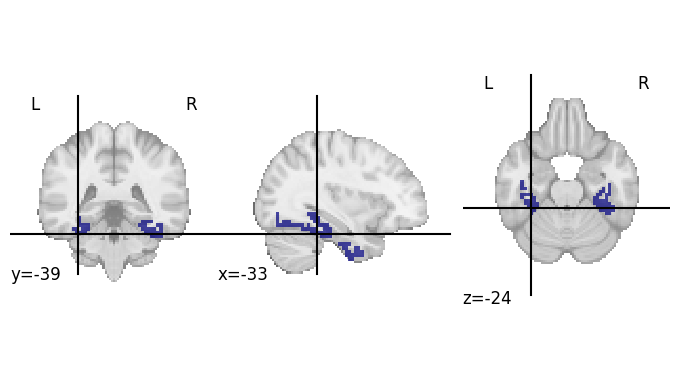

In [40]:
from nilearn.plotting import plot_roi
# borrow the affine transformation for this new image from their sibling
affine = nibabel.load(aparc.fpath).affine 
plot_roi(
    nibabel.nifti1.Nifti1Image(
        fusiform_mask*1.0,  # the plotting image requires a float-based mask
        affine=affine
    )
)

## Creating a Dataset

Now we are able to select only the betas for this ROI:

In [45]:
pattern = beta_img.get_fdata()[fusiform_mask]
pattern.shape, pattern[-10:]

((829, 1),
 array([[157.67828937],
        [  6.57029055],
        [  6.43865366],
        [  6.12197048],
        [-10.46893236],
        [ 16.69253657],
        [-72.01982946],
        [-17.89987039],
        [ -4.91374503],
        [ -1.04137262]]))

The run object then provides us with dictionaries with attributes that identify this run and its various dimensions. These map unto the rsatoolbox *descriptors*.

In [46]:
run.get_dataset_descriptors()

{'sub': '12', 'ses': '01', 'run': '01', 'task': 'main'}

We can then combine the patterns and descriptors to create an rsatoolbox `Dataset` object

In [55]:
ds = Dataset(
    measurements=pattern.T,
    descriptors=run.get_dataset_descriptors(),
    obs_descriptors=dict(condition=['image_glove']),
)

## Noise

If we want to apply multivariate noise normalization, we should also collect and process a measure of the noise of our observation. The *nilearn* glm can provide us with the residuals (e.g. error) of the GLM:

In [56]:
resid_img = glm.residuals[0]
resid_img.get_fdata().shape

(65, 77, 55, 546)

These we can also limit to the extend of our ROI:

In [60]:
resids = resid_img.get_fdata()[fusiform_mask, :].T
resids.shape

(546, 829)

Next we need to determine the degrees-of-freedom for our design. This is the number of columns in the design matrix figure above; 
- 32 stimulus conditions
- the "baseline" and "instruction" conditions
- 4 confound predictors

In [61]:
degrees_of_freedom = 38

We can then calculate a noise precision matrix:

In [62]:
prec_matrix = prec_from_residuals(
    resids,
    dof=degrees_of_freedom,
    method='shrinkage_diag'
)

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/rsatoolbox/data/noise.py:189: RuntimeWarning: invalid value encountered in divide
  s_mean = s_sum / np.expand_dims(std, 0) / np.expand_dims(std, 1) / (matrix.shape[0] - 1)
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/rsatoolbox/data/noise.py:190: RuntimeWarning: invalid value encountered in divide
  s2_mean = s2_sum / np.expand_dims(var, 0) / np.expand_dims(var, 1) / (matrix.shape[0] - 1)


## Calculating RDMs

Now that we have the Dataset and noise precision, we can calculate an RDM for this single run:

In [64]:
rdms = calc_rdm(
    dataset=ds,
    noise=prec_matrix,
    method='mahalanobis',
    descriptor='condition',
)

Now, instead of making an RDM for every run, we could use crossvalidation across the runs to get an RDM of the "crossnobis" dissimilarity. So let's loop across the runs:

In [22]:
datasets = []
prec_matrices = []

for run in runs:
    design_matrix = make_first_level_design_matrix(
        frame_times,
        run.get_events(),
        drift_model='polynomial',
        drift_order=3
    )
    glm = FirstLevelModel( ## necessary to redefine this? docs do not say if fit is idempotent
        t_r=2.0,
        mask_img=False,
        minimize_memory=False,
        signal_scaling=False,
    )
    glm.fit([run.boldFile.fpath], design_matrices=design_matrix)
    
    patterns = []
    for cond in conditions:
        z_map = glm.compute_contrast(f'{cond} - baseline', output_type='z_score')
        patterns.append(z_map.get_fdata()[it_mask])

    run_datasets.append(
        Dataset(
            measurements=numpy.asarray(patterns),
            descriptors=run.get_dataset_descriptors(),
            obs_descriptors=dict(trial_type=conditions),
        )
    )

    run_noise_sets.append(
        Dataset(
            measurements=glm.residuals[0].get_fdata()[it_mask].T,
            descriptors=run.get_dataset_descriptors(),
        )
    )
len(run_datasets)

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: response_time, identity, modality, task, response_mapping
  warnings.warn(
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0

18

In [41]:
run_datasets[0].measurements.shape

(32, 181)

In [26]:
run_datasets[0].obs_descriptors

{'trial_type': ['image_bagel',
  'image_brick',
  'image_candle',
  'image_clock',
  'image_glass',
  'image_glove',
  'image_helmet',
  'image_kettle',
  'image_knife',
  'image_ladder',
  'image_pedal',
  'image_saddle',
  'image_spade',
  'image_sponge',
  'image_table',
  'image_wheel',
  'text_bagel',
  'text_brick',
  'text_candle',
  'text_clock',
  'text_glass',
  'text_glove',
  'text_helmet',
  'text_kettle',
  'text_knife',
  'text_ladder',
  'text_pedal',
  'text_saddle',
  'text_spade',
  'text_sponge',
  'text_table',
  'text_wheel']}

Then pass this list to `calc_rdm` to compute the mahalanobis dissimilarity:

Let's plot the participant RDMs.

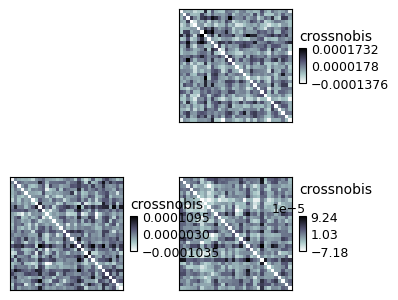

In [56]:
fig, _, _ = show_rdm(data_rdms, show_colorbar='panel')
matplotlib.pyplot.show()